## 加载模型


In [1]:
import os
import json
import time
import web
import numpy as np
from PIL import Image
from config import *
from apphelper.image import union_rbox,adjust_box_to_origin,base64_to_PIL
from application import trainTicket,idcard 
if yoloTextFlag =='keras' or AngleModelFlag=='tf' or ocrFlag=='keras':
    if GPU:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(GPUID)
        import tensorflow as tf
        from keras import backend as K
        config = tf.ConfigProto()
        config.gpu_options.allocator_type = 'BFC'
        config.gpu_options.per_process_gpu_memory_fraction = 0.3## GPU最大占用量
        config.gpu_options.allow_growth = True##GPU是否可动态增加
        K.set_session(tf.Session(config=config))
        K.get_session().run(tf.global_variables_initializer())
    
    else:
      ##CPU启动
      os.environ["CUDA_VISIBLE_DEVICES"] = ''

if yoloTextFlag=='opencv':
    scale,maxScale = IMGSIZE
    from text.opencv_dnn_detect import text_detect
elif yoloTextFlag=='darknet':
    scale,maxScale = IMGSIZE
    from text.darknet_detect import text_detect
elif yoloTextFlag=='keras':
    scale,maxScale = IMGSIZE[0],2048
    from text.keras_detect import  text_detect
else:
     print( "err,text engine in keras\opencv\darknet")
     
from text.opencv_dnn_detect import angle_detect

if ocr_redis:
    ##多任务并发识别
    from helper.redisbase import redisDataBase
    ocr = redisDataBase().put_values
else:   
    from crnn.keys import alphabetChinese,alphabetEnglish
    if ocrFlag=='keras':
        from crnn.network_keras import CRNN
        if chineseModel:
            alphabet = alphabetChinese
            if LSTMFLAG:
                ocrModel = ocrModelKerasLstm
            else:
                ocrModel = ocrModelKerasDense
        else:
            ocrModel = ocrModelKerasEng
            alphabet = alphabetEnglish
            LSTMFLAG = True
            
    elif ocrFlag=='torch':
        from crnn.network_torch import CRNN
        if chineseModel:
            alphabet = alphabetChinese
            if LSTMFLAG:
                ocrModel = ocrModelTorchLstm
            else:
                ocrModel = ocrModelTorchDense
                
        else:
            ocrModel = ocrModelTorchEng
            alphabet = alphabetEnglish
            LSTMFLAG = True
    elif ocrFlag=='opencv':
        from crnn.network_dnn import CRNN
        ocrModel = ocrModelOpencv
        alphabet = alphabetChinese
    else:
        print( "err,ocr engine in keras\opencv\darknet")
     
    nclass = len(alphabet)+1   
    if ocrFlag=='opencv':
        crnn = CRNN(alphabet=alphabet)
    else:
        crnn = CRNN( 32, 1, nclass, 256, leakyRelu=False,lstmFlag=LSTMFLAG,GPU=GPU,alphabet=alphabet)
    if os.path.exists(ocrModel):
        crnn.load_weights(ocrModel)
    else:
        print("download model or tranform model with tools!")
        
    ocr = crnn.predict_job
    
   
from main import TextOcrModel

model =  TextOcrModel(ocr,text_detect,angle_detect)
from apphelper.image import xy_rotate_box,box_rotate,solve


Instructions for updating:
Colocations handled automatically by placer.


2021-12-26 08:01:25.173977: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-12-26 08:01:25.194837: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3600000000 Hz
2021-12-26 08:01:25.195212: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55787008b640 executing computations on platform Host. Devices:
2021-12-26 08:01:25.195225: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


In [2]:
import cv2
import numpy as np
def plot_box(img,boxes):
    blue = (0, 0, 0) #18
    tmp = np.copy(img)
    for box in boxes:
         cv2.rectangle(tmp, (int(box[0]),int(box[1])), (int(box[2]), int(box[3])), blue, 1) #19
    
    return Image.fromarray(tmp) 

def plot_boxes(img,angle, result,color=(0,0,0)):
    tmp = np.array(img)
    c = color
    h,w = img.shape[:2]
    thick = int((h + w) / 300)
    i = 0
    if angle in [90,270]:
        imgW,imgH = img.shape[:2]
        
    else:
        imgH,imgW= img.shape[:2]

    for line in result:
        cx =line['cx']
        cy = line['cy']
        degree =line['degree']
        w  = line['w']
        h = line['h']

        x1,y1,x2,y2,x3,y3,x4,y4 = xy_rotate_box(cx, cy, w, h, degree/180*np.pi)
        
        x1,y1,x2,y2,x3,y3,x4,y4 = box_rotate([x1,y1,x2,y2,x3,y3,x4,y4],angle=(360-angle)%360,imgH=imgH,imgW=imgW)
        cx  =np.mean([x1,x2,x3,x4])
        cy  = np.mean([y1,y2,y3,y4])
        cv2.line(tmp,(int(x1),int(y1)),(int(x2),int(y2)),c,1)
        cv2.line(tmp,(int(x2),int(y2)),(int(x3),int(y3)),c,1)
        cv2.line(tmp,(int(x3),int(y3)),(int(x4),int(y4)),c,1)
        cv2.line(tmp,(int(x4),int(y4)),(int(x1),int(y1)),c,1)
        mess=str(i)
        cv2.putText(tmp, mess, (int(cx), int(cy)),0, 1e-3 * h, c, thick // 2)
        i+=1
    return Image.fromarray(tmp).convert('RGB')


def plot_rboxes(img,boxes,color=(0,0,0)):
    tmp = np.array(img)
    c = color
    h,w = img.shape[:2]
    thick = int((h + w) / 300)
    i = 0


    for box in boxes:

        x1,y1,x2,y2,x3,y3,x4,y4 = box
        
        
        cx  =np.mean([x1,x2,x3,x4])
        cy  = np.mean([y1,y2,y3,y4])
        cv2.line(tmp,(int(x1),int(y1)),(int(x2),int(y2)),c,1)
        cv2.line(tmp,(int(x2),int(y2)),(int(x3),int(y3)),c,1)
        cv2.line(tmp,(int(x3),int(y3)),(int(x4),int(y4)),c,1)
        cv2.line(tmp,(int(x4),int(y4)),(int(x1),int(y1)),c,1)
        mess=str(i)
        cv2.putText(tmp, mess, (int(cx), int(cy)),0, 1e-3 * h, c, thick // 2)
        i+=1
    return Image.fromarray(tmp).convert('RGB')

It take:1.3465580940246582s
姓名代用名
性别男民族汉
出生2013年05月06日
住址湖南省长沙市开福区巡道街
幸福小区居民组
公民身份证号码430512198908131367


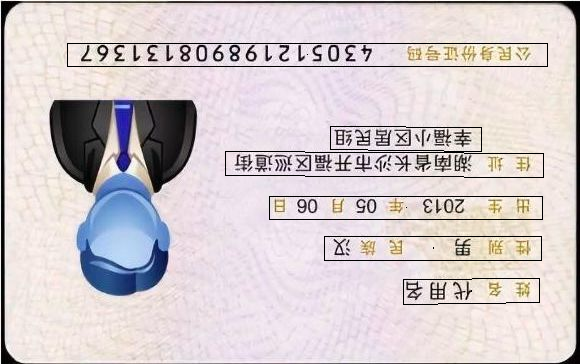

In [3]:
import time
from PIL import Image
p = './test/idcard-demo.jpeg'
img = cv2.imread(p)

h,w = img.shape[:2]
timeTake = time.time()
scale=608
maxScale=2048

result,angle= model.model(img,
                                    detectAngle=True,##是否进行文字方向检测
                                    scale=scale,
                                    maxScale=maxScale,
                                    MAX_HORIZONTAL_GAP=80,##字符之间的最大间隔，用于文本行的合并
                                    MIN_V_OVERLAPS=0.6,
                                    MIN_SIZE_SIM=0.6,
                                    TEXT_PROPOSALS_MIN_SCORE=0.1,
                                    TEXT_PROPOSALS_NMS_THRESH=0.7,
                                    TEXT_LINE_NMS_THRESH = 0.9,##文本行之间测iou值
                                     LINE_MIN_SCORE=0.1,                                             
                                    leftAdjustAlph=0,##对检测的文本行进行向左延伸
                                    rightAdjustAlph=0.1,##对检测的文本行进行向右延伸
                                   )
        
timeTake = time.time()-timeTake

print('It take:{}s'.format(timeTake))
for line in result:
    print(line['text'])
plot_boxes(img,angle, result,color=(0,0,0))

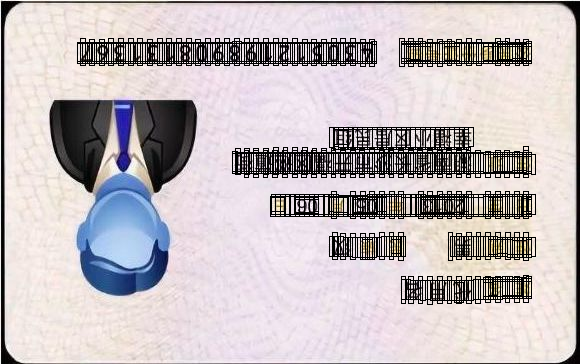

In [4]:
boxes,scores  = model.detect_box(img,608,2048)
plot_box(img,boxes)

It take:0.8034648895263672s




束



UI
枝


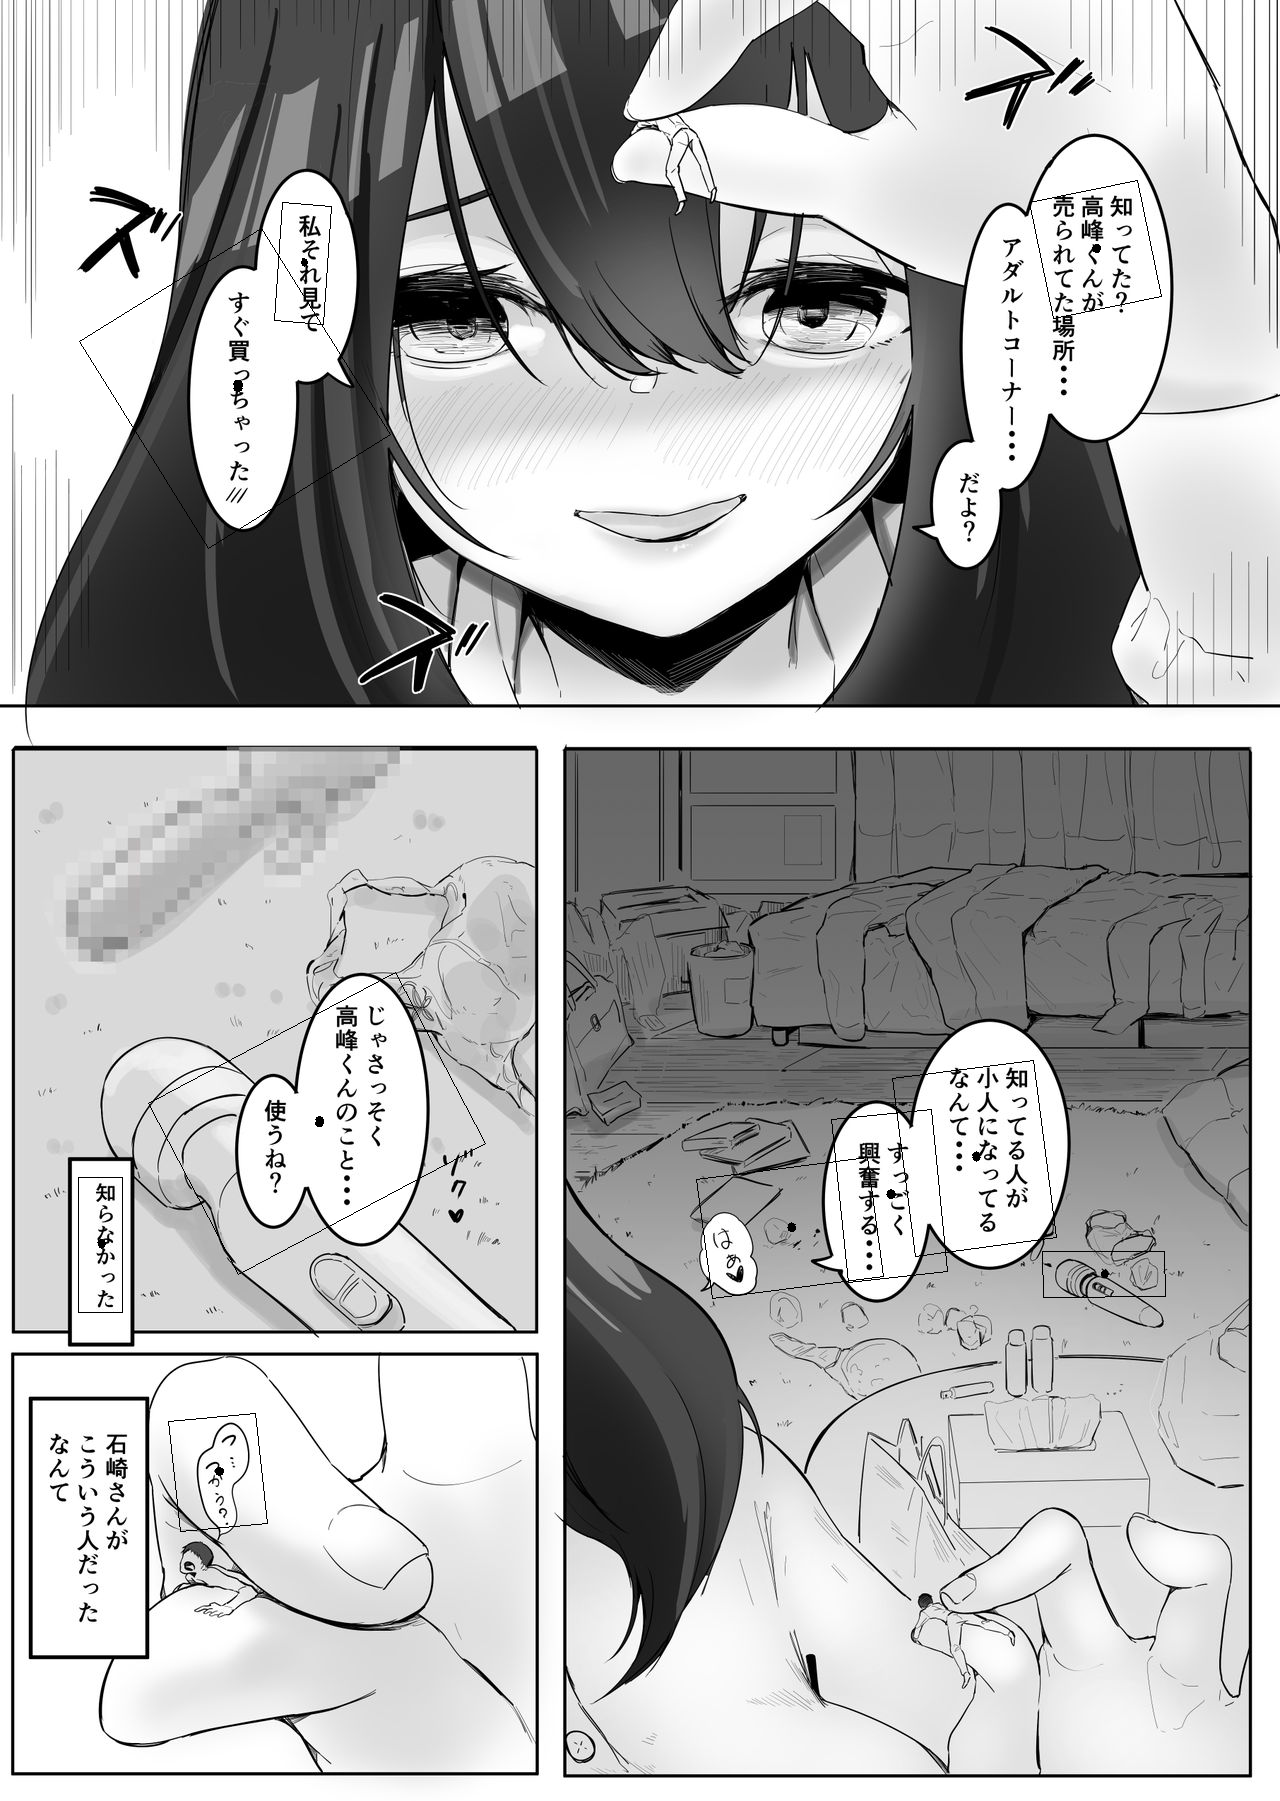

In [6]:
import time
from PIL import Image
p = '/home/mohan/GitRepos/ocrproj/data/manga/raw/japan/[Marushamo} Chīsaku natta jibun o katta no ga mukashi no dōkyūseidatta hanashi-jō/06.jpg'
img = cv2.imread(p)

h,w = img.shape[:2]
timeTake = time.time()'/home/mohan/GitRepos/ocrproj/data/manga/raw/chinese_cht/[Marushamo] Chiisaku Natta Jibun o Katta no ga Mukashi no Doukyuusei Datta Hanashi Jou [Chinese] [沒有漢化]/05.jpg'
scale=608
maxScale=2048

result,angle= model.model(img,
                                    detectAngle=True,##是否进行文字方向检测
                                    scale=scale,
                                    maxScale=maxScale,
                                    MAX_HORIZONTAL_GAP=80,##字符之间的最大间隔，用于文本行的合并
                                    MIN_V_OVERLAPS=0.6,
                                    MIN_SIZE_SIM=0.6,
                                    TEXT_PROPOSALS_MIN_SCORE=0.1,
                                    TEXT_PROPOSALS_NMS_THRESH=0.7,
                                    TEXT_LINE_NMS_THRESH = 0.9,##文本行之间测iou值
                                     LINE_MIN_SCORE=0.1,                                             
                                    leftAdjustAlph=0,##对检测的文本行进行向左延伸
                                    rightAdjustAlph=0.1,##对检测的文本行进行向右延伸
                                   )
        
timeTake = time.time()-timeTake

print('It take:{}s'.format(timeTake))
for line in result:
    print(line['text'])
plot_boxes(img,angle, result,color=(0,0,0))